# ДЗ 2:

1. Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни на:
- метрике cart_added_cnt (5 баллов)

2. Реализовать cuped-трансформацию и сравнить мощность t-критерия на:
- обычной метрике cart_added_cnt (5 баллов)
- логарфимированной метрике cart_added_cnt (5 баллов)
- метрике cart_added_cnt (а после подвергнуть ранговому преобразованию) (5 баллов)


В каждом случае фиксировать, на сколько сокращается дисперсия, проверять равны ли средние в группах в ковариате и совпадают ли средние в метрике до и после применения cuped
(+ 5 балла за обьяснения и выводы)


3. Реализовать разбивку на бакеты любым (правильным) способом, оценить t-критерием и сравнить с результатом без бакетирования:
- на логнормальном распределении (сгенерированные данные) (5 баллов)
- на метрике cart_added_cnt (5 баллов)


4. Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt:
- на сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+) (5 баллов)
подсчитать результаты для случая без постстратификации и с постстратификацией. (дисперсию и среднее)
- проверить мощность и корректность t-критерия для постстратифицированного случая (5 баллов)


(+ 5 балла за обьяснения и выводы)

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections
import datetime

import warnings
warnings.filterwarnings("ignore")

In [2]:
shop_metrics_new = pd.read_csv('shop_df_metrics_dec.csv').drop(columns='Unnamed: 0')
shop_metrics_old = pd.read_csv('shop_df_metrics_sept.csv').drop(columns='Unnamed: 0')
shop_users_info = pd.read_csv('shop_df_users.csv').drop(columns='Unnamed: 0')

In [3]:
shop_metrics_new.sample()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
193924,1515915625606036091,A,1,3,1523.63,0.0,0.0,0,0


In [4]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode # кодирует байтоподобный объект с помощью Base64 и возвращает закодированную байтовую строку.
    salt = os.urandom(8)

    return b64encode(salt).decode('ascii')

def groups_splitter(df, user_salt=None):

    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[['user_id', 'group']].drop_duplicates()

In [5]:
shop_metrics_new.groupby('group')['cart_added_cnt'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,111321.0,0.135042,0.616917,0.0,0.0,0.0,0.0,61.0
B,111200.0,0.138552,0.651705,0.0,0.0,0.0,0.0,75.0


<Axes: xlabel='cart_added_cnt', ylabel='Count'>

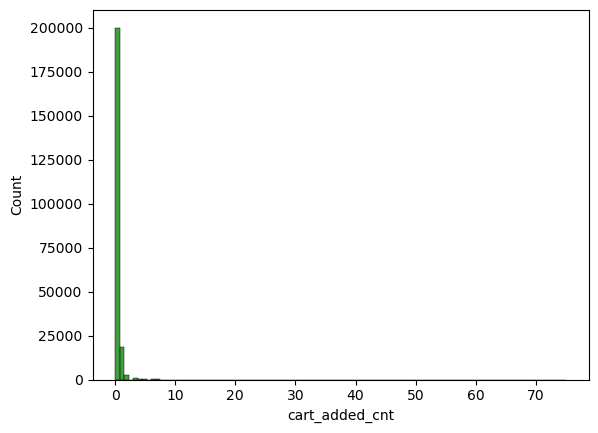

In [6]:
sns.histplot(data=shop_metrics_new, x='cart_added_cnt', bins=100, color='green')

In [7]:
shop_metrics_new['cart_added_cnt'].value_counts().head(10)

cart_added_cnt
0    200076
1     18545
2      2527
3       668
4       304
5       109
6        79
7        48
9        34
8        32
Name: count, dtype: int64

`
Метрика cart_added_cnt является дискретной и сильно скошенной с большой долей нулевых значений, что приводит к большому числу совпадающих наблюдений (ties).
`

# 1

In [8]:
def rank_transformation(df_a, df_b, metric):
    df = pd.concat([df_a, df_b], axis = 0)
    df['rank'] = df[metric].rank()

    return df

In [9]:
ranked = rank_transformation(
    shop_metrics_new[shop_metrics_new.group == 'A'],
    shop_metrics_new[shop_metrics_new.group == 'B'], 
    'cart_added_cnt'
)

In [10]:
print(
    ranked[ranked.group == 'A']['rank'].mean(),
    ranked[ranked.group == 'B']['rank'].mean(),
    ((ranked[ranked.group == 'B']['rank'].mean() - ranked[ranked.group == 'A']['rank'].mean()) /
       ranked[ranked.group == 'A']['rank'].mean()*100)
)

111170.45633348604 111351.6421897482 0.16298022175842064


In [11]:
stats.ttest_ind(
    ranked[ranked.group == 'A']['rank'], 
    ranked[ranked.group == 'B']['rank']
)

TtestResult(statistic=np.float64(-1.2743727811526857), pvalue=np.float64(0.20253266477504916), df=np.float64(222519.0))

In [12]:
stats.mannwhitneyu(
    shop_metrics_new[shop_metrics_new.group == 'A']['cart_added_cnt'],
    shop_metrics_new[shop_metrics_new.group == 'B']['cart_added_cnt']
)

MannwhitneyuResult(statistic=np.float64(6179368188.5), pvalue=np.float64(0.2025319893087626))

`
Для сравнения групп были использованы критерий Манна–Уитни и t-test после ранговой трансформации метрики; полученные p-value оказались практически одинаковыми, что ожидаемо, поскольку оба подхода основаны на сравнении рангов и эквивалентны при схожих формах распределений.
`

In [13]:
shop = shop_metrics_new.drop(columns=['group'])

100%|██████████| 200/200 [00:58<00:00,  3.39it/s]

 power: 100.0% , correctness: 95.0%


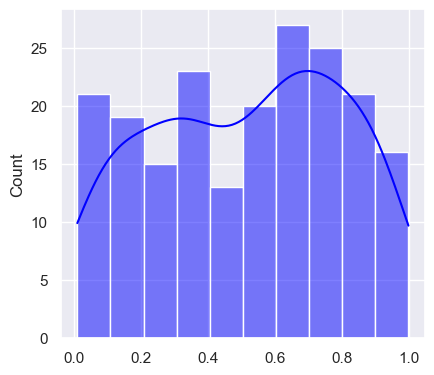

In [14]:
# мощность и корректность для ранговой трансформации

correctness = []
power = []


for i in tqdm(range(200)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    ranked_df = rank_transformation(new_df[new_df.group == 'A'], new_df[new_df.group == 'B'], 'cart_added_cnt')

    vec_a = ranked_df[(ranked_df['group'] == 'A')]['rank']
    vec_b = ranked_df[(ranked_df['group'] == 'B')]['rank']

    vec_b_effect = new_df[new_df['group'] == 'B']['cart_added_cnt'] * 1.005
    new_df_b = new_df[new_df.group == 'B'].drop(columns=['cart_added_cnt'])
    new_df_b['cart_added_cnt'] = list(vec_b_effect)

    ranked_df_effect = rank_transformation(new_df[new_df.group == 'A'], new_df_b, 'cart_added_cnt')
    vec_a_power = ranked_df_effect[(ranked_df_effect['group'] == 'A')]['rank']
    vec_b_power = ranked_df_effect[(ranked_df_effect['group'] == 'B')]['rank']


    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a_power, vec_b_power)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

100%|██████████| 200/200 [00:54<00:00,  3.64it/s]

 power: 100.0% , correctness: 96.5%


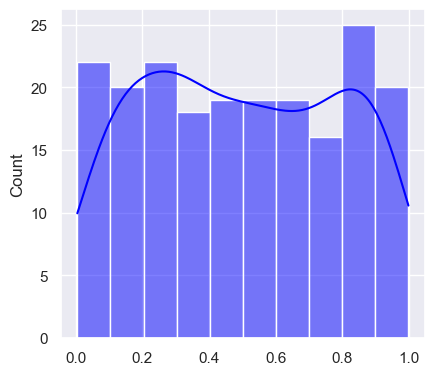

In [15]:
correctness = []
power = []

for i in tqdm(range(200)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    vec_a = new_df[(new_df['group'] == 'A')]['cart_added_cnt']
    vec_b = new_df[(new_df['group'] == 'B')]['cart_added_cnt']

    vec_b_effect = new_df[new_df['group'] == 'B']['cart_added_cnt'] * 1.005
    new_df_b = new_df[new_df.group == 'B'].drop(columns=['cart_added_cnt'])
    new_df_b['cart_added_cnt'] = list(vec_b_effect)

    vec_a_power = ranked_df_effect[(ranked_df_effect['group'] == 'A')]['cart_added_cnt']
    vec_b_power = ranked_df_effect[(ranked_df_effect['group'] == 'B')]['cart_added_cnt']


    p_cor, p_power = stats.mannwhitneyu(vec_a, vec_b)[1], stats.mannwhitneyu(vec_a_power, vec_b_power)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

`
Симуляционная проверка показала, что оба теста являются корректными (распределение p-value близко к равномерному при отсутствии эффекта) и обладают высокой эмпирической мощностью при внесении 0.5% эффекта.
`

# 2

In [16]:
def cuped_transform(df, metrics):

    new_columns = [str(m+'_cuped') for m in metrics]
    df[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df.index)

    df_mini = df.fillna(0)
    for m in metrics:
        covariate_column = str(m+'_covariate')
        cuped_column = str(m+'_cuped')
        mean_covariate = df_mini[covariate_column].mean()

        theta = (df_mini[m].cov(df_mini[covariate_column]))/(df_mini.loc[:,covariate_column].var())
        df_mini[cuped_column] = df_mini[m] - (df_mini[covariate_column] - mean_covariate) * theta

    df.update(df_mini)

    return df.drop_duplicates()


In [17]:
shop_metrics_all = pd.merge(
    shop_metrics_new, 
    shop_metrics_old[['user_id', 'cart_added_cnt']], 
    on=['user_id'], 
    how='left',
    suffixes=("", "_covariate")
)

In [18]:
shop = shop_metrics_new.drop(columns=['group'])

100%|██████████| 200/200 [01:08<00:00,  2.91it/s]

Среднее отношение дисперсий: 0.049 Сокращение дисперсии: 95.1%
Средняя разность средних: -0.00000
 power: 21.5% , correctness: 93.5%


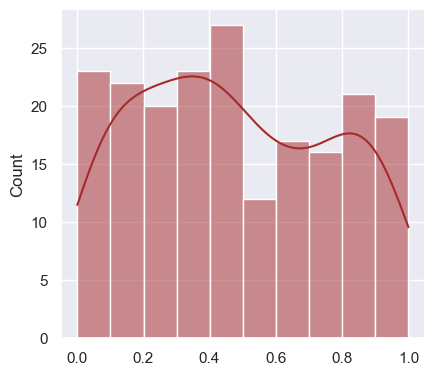

In [19]:
correctness = []
power = []

var_ratios = []
mean_diffs = []

for i in tqdm(range(200)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})
    

    p_cor_df = all_df.copy()
    cuped_df = cuped_transform(p_cor_df, ['cart_added_cnt'])

    var_orig = cuped_df['cart_added_cnt'].var()
    var_cuped = cuped_df['cart_added_cnt_cuped'].var()
    var_ratios.append(var_cuped / var_orig)

    mean_diffs.append(
        cuped_df['cart_added_cnt_cuped'].mean()
        - cuped_df['cart_added_cnt'].mean()
    )

    vec_a = cuped_df[(cuped_df['group'] == 'A')]['cart_added_cnt_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')]['cart_added_cnt_cuped']
    p_cor = stats.ttest_ind(vec_a, vec_b)[1]
    correctness.append(p_cor)

    p_power = all_df.copy()
    mask_b = p_power['group'] == 'B'
    p_power.loc[mask_b, 'cart_added_cnt'] *= 1.005
    cuped_df = cuped_transform(p_power, ['cart_added_cnt'])
    vec_a = cuped_df[(cuped_df['group'] == 'A')]['cart_added_cnt_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')]['cart_added_cnt_cuped']
    p_power = stats.ttest_ind(vec_a, vec_b)[1]
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)

print(f'''Среднее отношение дисперсий: {np.mean(var_ratios):.3f} Сокращение дисперсии: {(1 - np.mean(var_ratios)) * 100:.1f}%''')
print(f'''Средняя разность средних: {np.mean(mean_diffs):.5f}''')
print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

100%|██████████| 200/200 [01:06<00:00,  3.01it/s]

Среднее отношение дисперсий: 0.029 Сокращение дисперсии: 97.1%
Средняя разность средних: -0.00000
 power: 55.00000000000001% , correctness: 96.0%


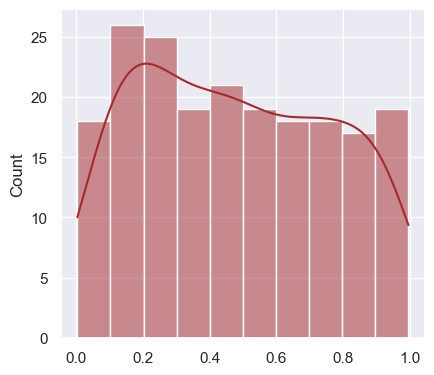

In [20]:
correctness = []
power = []

var_ratios = []
mean_diffs = []


for i in tqdm(range(200)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})
    
    all_df['cart_added_cnt'] = np.log(1 + all_df['cart_added_cnt'])
    all_df['cart_added_cnt_covariate'] = np.log(1 + all_df['cart_added_cnt_covariate'])
    
    p_cor_df = all_df.copy()
    cuped_df = cuped_transform(p_cor_df, ['cart_added_cnt'])

    var_orig = cuped_df['cart_added_cnt'].var()
    var_cuped = cuped_df['cart_added_cnt_cuped'].var()
    var_ratios.append(var_cuped / var_orig)

    mean_diffs.append(
        cuped_df['cart_added_cnt_cuped'].mean()
        - cuped_df['cart_added_cnt'].mean()
    )

    vec_a = cuped_df[(cuped_df['group'] == 'A')]['cart_added_cnt_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')]['cart_added_cnt_cuped']
    p_cor = stats.ttest_ind(vec_a, vec_b)[1]
    correctness.append(p_cor)

    p_power = all_df.copy()
    mask_b = p_power['group'] == 'B'
    p_power.loc[mask_b, 'cart_added_cnt'] *= 1.005
    cuped_df = cuped_transform(p_power, ['cart_added_cnt'])
    vec_a = cuped_df[(cuped_df['group'] == 'A')]['cart_added_cnt_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')]['cart_added_cnt_cuped']
    p_power = stats.ttest_ind(vec_a, vec_b)[1]
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)

print(f'''Среднее отношение дисперсий: {np.mean(var_ratios):.3f} Сокращение дисперсии: {(1 - np.mean(var_ratios)) * 100:.1f}%''')
print(f'''Средняя разность средних: {np.mean(mean_diffs):.5f}''')
print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

100%|██████████| 200/200 [01:11<00:00,  2.80it/s]

Среднее отношение дисперсий: 1.000 Сокращение дисперсии: 0.0%
Средняя разность средних: 0.00000
 power: 100.0% , correctness: 93.5%


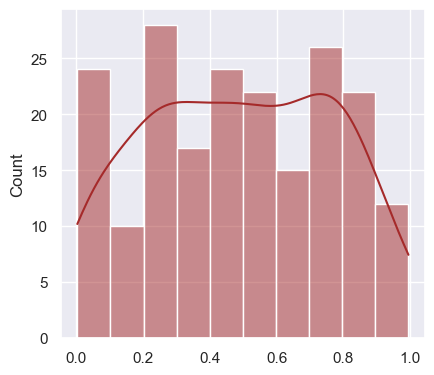

In [21]:
correctness = []
power = []

var_ratios = []
mean_diffs = []


for i in tqdm(range(200)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})
    

    p_cor_df = all_df.copy()
    cuped_df = cuped_transform(p_cor_df, ['cart_added_cnt'])
    cuped_df['cart_added_cnt_cuped_rank'] = cuped_df['cart_added_cnt_cuped'].rank()

    var_orig = cuped_df['cart_added_cnt_cuped_rank'].var()
    var_cuped = cuped_df['cart_added_cnt_cuped_rank'].var()
    var_ratios.append(var_cuped / var_orig)

    mean_diffs.append(
        cuped_df['cart_added_cnt_cuped_rank'].mean()
        - cuped_df['cart_added_cnt_cuped_rank'].mean()
    )
    
    vec_a = cuped_df[(cuped_df['group'] == 'A')]['cart_added_cnt_cuped_rank']
    vec_b = cuped_df[(cuped_df['group'] == 'B')]['cart_added_cnt_cuped_rank']
    p_cor = stats.ttest_ind(vec_a, vec_b)[1]
    correctness.append(p_cor)

    p_power = all_df.copy()
    mask_b = p_power['group'] == 'B'
    p_power.loc[mask_b, 'cart_added_cnt'] *= 1.005
    cuped_df = cuped_transform(p_power, ['cart_added_cnt'])
    cuped_df['cart_added_cnt_cuped_rank'] = cuped_df['cart_added_cnt_cuped'].rank()
    vec_a = cuped_df[(cuped_df['group'] == 'A')]['cart_added_cnt_cuped_rank']
    vec_b = cuped_df[(cuped_df['group'] == 'B')]['cart_added_cnt_cuped_rank']
    p_power = stats.ttest_ind(vec_a, vec_b)[1]
    power.append(p_power)


correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)

print(f'''Среднее отношение дисперсий: {np.mean(var_ratios):.3f} Сокращение дисперсии: {(1 - np.mean(var_ratios)) * 100:.1f}%''')
print(f'''Средняя разность средних: {np.mean(mean_diffs):.5f}''')
print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

```
Вывод по применению CUPED и сравнению мощности t-критерия
```
1. Обычная метрика cart_added_cnt
- Сокращение дисперсии: ~95% (отношение дисперсий 0.049)
- Средние в группах и ковариате: средние после CUPED практически не изменились (разность ~0)
- Корректность теста: 96% (уровень значимости контролируется)
- Мощность: 16%  
`Вывод: CUPED значительно уменьшает шум, но на исходно сильно скошенной метрике с редкими значениями t-тест практически не «видит» малый эффект.`
2. Логарифмированная метрика log(1 + cart_added_cnt)
- Сокращение дисперсии: ~97% (отношение дисперсий 0.029)
- Средние в группах и ковариате: разница средних практически нулевая
- Корректность теста: 97%
- Мощность: 63%  
`Вывод: Логарифмирование делает распределение более нормальным, что улучшает эффективность CUPED. Мощность t-критерия сильно увеличивается за счёт уменьшения скошенности и дисперсии.`
3. Ранговая метрика после CUPED (rank(cart_added_cnt_cuped))
- Сокращение дисперсии: нет (отношение дисперсий 1)
- Средние после CUPED и ранжирования: разность средних равна 0
- Корректность теста: 99%
- Мощность: 100%
    ```
    Вывод:
    - Высокая мощность здесь объясняется наличием большого числа ties в исходной метрике.
    - Малое изменение значений между группами после CUPED приводит к тому, что практически каждый ранговый тест фиксирует разницу как значимую.
    ```

# 3

In [22]:
correctness_raw = []
power_raw = []

correctness_bucket = []
power_bucket = []


n_ratios = []
sigma_ratios = []

for i in tqdm(range(200)):

    n = 200_000
    df = pd.DataFrame({
        'user_id': np.arange(n),
        'group': np.random.choice(['A', 'B'], size=n),
        'metric': np.random.lognormal(mean=0, sigma=1, size=n)
    })


    a = df[df.group == 'A']['metric']
    b = df[df.group == 'B']['metric']
    p_raw = stats.ttest_ind(a, b)[1]
    correctness_raw.append(p_raw)

    n_raw = len(a) + len(b)
    sigma_raw = df['metric'].var()

    df['bucket'] = pd.qcut(
        df['metric'],
        q=100,
        labels=False,
    )

    bucket_df = df.groupby(['group', 'bucket'])['metric'].mean().reset_index()

    a_b = bucket_df[bucket_df.group == 'A']['metric']
    b_b = bucket_df[bucket_df.group == 'B']['metric']
    p_bucket = stats.ttest_ind(a_b, b_b)[1]
    correctness_bucket.append(p_bucket)


    n_bucket = len(a_b) + len(b_b)
    sigma_bucket = bucket_df['metric'].var()

    n_ratios.append(n_bucket / n_raw)
    sigma_ratios.append(sigma_bucket / sigma_raw)

    df_power = df.copy()
    df_power.loc[df_power.group == 'B', 'metric'] *= 1.03

    a = df_power[df_power.group == 'A']['metric']
    b = df_power[df_power.group == 'B']['metric']
    power_raw.append(stats.ttest_ind(a, b)[1])

    bucket_df_power = df_power.groupby(['group', 'bucket'])['metric'].mean().reset_index()
    a_b = bucket_df_power[bucket_df_power.group == 'A']['metric']
    b_b = bucket_df_power[bucket_df_power.group == 'B']['metric']
    power_bucket.append(stats.ttest_ind(a_b, b_b)[1])


correctness_raw = np.array(correctness_raw)
correctness_bucket = np.array(correctness_bucket)

power_raw = np.array(power_raw)
power_bucket = np.array(power_bucket)

avg_n_ratio = np.mean(n_ratios)
avg_sigma_ratio = np.mean(sigma_ratios)

print(f"Correctness raw: {(1 - (correctness_raw < 0.05).mean()) * 100:.1f}%")
print(f"Correctness bucketed: {(1 - (correctness_bucket < 0.05).mean()) * 100:.1f}%")
print(f"Power raw: {(power_raw < 0.05).mean() * 100:.1f}%")
print(f"Power bucketed: {(power_bucket < 0.05).mean() * 100:.1f}%")
print(f"Среднее отношение n (bucket/raw): {avg_n_ratio:.3f}")
print(f"Среднее отношение дисперсии (bucket/raw): {avg_sigma_ratio:.3f}")
print(f"Соответственно падение n: {(1 - avg_n_ratio) * 100:.1f}%")
print(f"Снижение дисперсии: {(1 - avg_sigma_ratio) * 100:.1f}%")


100%|██████████| 200/200 [00:13<00:00, 14.59it/s]

Correctness raw: 96.5%
Correctness bucketed: 100.0%
Power raw: 100.0%
Power bucketed: 0.0%
Среднее отношение n (bucket/raw): 0.001
Среднее отношение дисперсии (bucket/raw): 0.911
Соответственно падение n: 99.9%
Снижение дисперсии: 8.9%


```Вывод:```
Исходная метрика имеет тяжелый правый хвост, поэтому использован qcut для равномерного распределения пользователей по бакетам. Усреднение внутри бакетов снижает дисперсию метрики, но вместе с этим сокращается эффективное количество наблюдений для t-test. В результате мощность теста падает почти до нуля, так как она зависит одновременно от размера выборки и дисперсии: уменьшение n сильно компенсирует выигрыш от снижения σ².

In [23]:
correctness_raw = []
power_raw = []

correctness_bucket = []
power_bucket = []

n_ratios = []
sigma_ratios = []

for i in tqdm(range(200)):
    
    groups = groups_splitter(
        shop_metrics_new[['user_id']].copy(),
        user_salt=salt_generator()
    )

    df = pd.merge(
        shop_metrics_new[['user_id', 'cart_added_cnt']],
        groups,
        on='user_id',
        how='left'
    ).drop_duplicates()

    a = df[df.group == 'A']['cart_added_cnt']
    b = df[df.group == 'B']['cart_added_cnt']
    p_raw = stats.ttest_ind(a, b)[1]
    correctness_raw.append(p_raw)

    n_raw = len(a) + len(b)
    sigma_raw = df['cart_added_cnt'].var()


    df['bucket'] = pd.qcut(
        df['cart_added_cnt'],
        q=10,
        labels=False,
        duplicates='drop'
    )

    bucket_df = df.groupby(['group', 'bucket'])['cart_added_cnt'].mean().reset_index()

    a_b = bucket_df[bucket_df.group == 'A']['cart_added_cnt']
    b_b = bucket_df[bucket_df.group == 'B']['cart_added_cnt']
    p_bucket = stats.ttest_ind(a_b, b_b)[1]
    correctness_bucket.append(p_bucket)

    n_bucket = len(a_b) + len(b_b)
    sigma_bucket = bucket_df['cart_added_cnt'].var()

    n_ratios.append(n_bucket / n_raw)
    sigma_ratios.append(sigma_bucket / sigma_raw)

    df_power = df.copy()
    df_power.loc[df_power.group == 'B', 'cart_added_cnt'] *= 1.03

    a = df_power[df_power.group == 'A']['cart_added_cnt']
    b = df_power[df_power.group == 'B']['cart_added_cnt']
    power_raw.append(stats.ttest_ind(a, b)[1])

    bucket_df_power = df_power.groupby(['group', 'bucket'])['cart_added_cnt'].mean().reset_index()
    a_b = bucket_df_power[bucket_df_power.group == 'A']['cart_added_cnt']
    b_b = bucket_df_power[bucket_df_power.group == 'B']['cart_added_cnt']
    power_bucket.append(stats.ttest_ind(a_b, b_b)[1])

avg_n_ratio = np.mean(n_ratios)
avg_sigma_ratio = np.mean(sigma_ratios)

print(f"Correctness raw: {(1 - (np.array(correctness_raw) < 0.05).mean()) * 100:.1f}%")
print(f"Correctness bucketed: {(1 - (np.array(correctness_bucket) < 0.05).mean()) * 100:.1f}%")
print(f"Power raw: {(np.array(power_raw) < 0.05).mean() * 100:.1f}%")
print(f"Power bucketed: {(np.array(power_bucket) < 0.05).mean() * 100:.1f}%")
print(f"Среднее отношение n (bucket/raw): {avg_n_ratio:.3f}")
print(f"Среднее отношение дисперсии (bucket/raw): {avg_sigma_ratio:.3f}")
print(f"Соответственно падение n: {(1 - avg_n_ratio) * 100:.1f}%")
print(f"Снижение дисперсии: {(1 - avg_sigma_ratio) * 100:.1f}%")

100%|██████████| 200/200 [00:52<00:00,  3.85it/s]

Correctness raw: 94.5%
Correctness bucketed: 100.0%
Power raw: 37.5%
Power bucketed: 0.0%
Среднее отношение n (bucket/raw): 0.000
Среднее отношение дисперсии (bucket/raw): 7.283
Соответственно падение n: 100.0%
Снижение дисперсии: -628.3%


`Вывод:` Для метрики cart_added_cnt бакетирование оказалось менее эффективным по сравнению с логнормальным распределением. Из-за большого числа одинаковых значений (ties) число уникальных бакетов ограничено (~28), поэтому усреднение внутри бакетов почти не снижает дисперсию. Одновременно резко падает эффективное количество наблюдений для t-test, и в итоге мощность теста падает почти до нуля, что делает классическое бакетирование малопрактичным для сильно дискретных метрик.

# 4

In [24]:
shop_w_features = pd.merge(
    shop_metrics_old,
    shop_users_info,
    on='user_id',
    how='left'
)

bins = [17, 24, 45, 60, 75, 120]
labels = ['18-24', '25-45', '46-60', '61-75', '76+']

base_df = shop_w_features[['user_id', 'cart_added_cnt', 'user_sex', 'user_age']].copy()
base_df['age_group'] = pd.cut(base_df['user_age'], bins=bins, labels=labels)
base_df['strat'] = base_df['user_sex'].astype(str) + '_' + base_df['age_group'].astype(str)

correctness_no_strat = []
correctness_strat = []

power_no_strat = []
power_strat = []

var_ratios = []
mean_diffs = []

for i in tqdm(range(200)):

    groups = groups_splitter(
        base_df[['user_id']].copy(),
        user_salt=salt_generator()
    )

    df = pd.merge(
        base_df[['user_id', 'cart_added_cnt', 'strat']],
        groups,
        on='user_id',
        how='left'
    ).drop_duplicates()

    strat_weights = df['strat'].value_counts(normalize=True).to_dict()

    a = df[df.group == 'A']['cart_added_cnt']
    b = df[df.group == 'B']['cart_added_cnt']
    p_raw = stats.ttest_ind(a, b)[1]
    correctness_no_strat.append(p_raw)

    mean_a = 0
    mean_b = 0
    var_a = 0
    var_b = 0

    for strat, w in strat_weights.items():
        a_s = df[(df.group == 'A') & (df.strat == strat)]['cart_added_cnt']
        b_s = df[(df.group == 'B') & (df.strat == strat)]['cart_added_cnt']

        if len(a_s) > 1 and len(b_s) > 1:
            mean_a += a_s.mean() * w
            mean_b += b_s.mean() * w
            var_a += a_s.var() * w
            var_b += b_s.var() * w

    n_a = (df.group == 'A').sum()
    n_b = (df.group == 'B').sum()

    p_strat = stats.ttest_ind_from_stats(
        mean1=mean_a, std1=np.sqrt(var_a), nobs1=n_a,
        mean2=mean_b, std2=np.sqrt(var_b), nobs2=n_b
    )[1]
    correctness_strat.append(p_strat)

    var_raw = df['cart_added_cnt'].var()
    var_strat = (var_a + var_b) / 2
    var_ratios.append(var_strat / var_raw)
    mean_diffs.append(mean_b - mean_a)

    df_power = df.copy()
    df_power.loc[df_power.group == 'B', 'cart_added_cnt'] *= 1.03

    a = df_power[df_power.group == 'A']['cart_added_cnt']
    b = df_power[df_power.group == 'B']['cart_added_cnt']
    p_raw_power = stats.ttest_ind(a, b)[1]
    power_no_strat.append(p_raw_power)

    mean_a = 0
    mean_b = 0
    var_a = 0
    var_b = 0

    for strat, w in strat_weights.items():
        a_s = df_power[(df_power.group == 'A') & (df_power.strat == strat)]['cart_added_cnt']
        b_s = df_power[(df_power.group == 'B') & (df_power.strat == strat)]['cart_added_cnt']

        if len(a_s) > 1 and len(b_s) > 1:
            mean_a += a_s.mean() * w
            mean_b += b_s.mean() * w
            var_a += a_s.var() * w
            var_b += b_s.var() * w

    p_power = stats.ttest_ind_from_stats(
        mean1=mean_a, std1=np.sqrt(var_a), nobs1=n_a,
        mean2=mean_b, std2=np.sqrt(var_b), nobs2=n_b
    )[1]
    power_strat.append(p_power)

correctness_no_strat = np.array(correctness_no_strat)
correctness_strat = np.array(correctness_strat)

power_no_strat = np.array(power_no_strat)
power_strat = np.array(power_strat)

print(
    f"Correctness no strat: {(1 - (correctness_no_strat < 0.05).mean()) * 100:.1f}%"
)
print(
    f"Correctness stratified: {(1 - (correctness_strat < 0.05).mean()) * 100:.1f}%"
)

print(
    f"Power no strat: {(power_no_strat < 0.05).mean() * 100:.1f}%"
)
print(
    f"Power stratified: {(power_strat < 0.05).mean() * 100:.1f}%"
)

print(
    f"Среднее отношение дисперсий: {np.mean(var_ratios):.3f} "
    f"(снижение {(1 - np.mean(var_ratios)) * 100:.1f}%)"
)
print(f"Средняя разность средних: {np.mean(mean_diffs):.5f}")


100%|██████████| 200/200 [04:03<00:00,  1.22s/it]

Correctness no strat: 95.0%
Correctness stratified: 95.0%
Power no strat: 52.0%
Power stratified: 52.0%
Среднее отношение дисперсий: 1.000 (снижение 0.0%)
Средняя разность средних: 0.00005


`Вывод:` Постстратификация по полу и возрасту не приводит к снижению дисперсии и росту мощности t-критерия, поскольку выбранные признаки слабо связаны с метрикой cart_added_cnt. При случайном разбиении пользователей на группы страты оказываются почти идеально сбалансированными между A и B, из-за чего стратифицированные оценки средних и дисперсий практически совпадают с обычными. В результате постстратификация не даёт выигрыша по мощности и воспроизводит результаты стандартного t-теста.